#### Imports

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from autoreject import AutoReject
from mne.preprocessing import ICA
from mne_icalabel import label_components

#### Practice

In [ ]:
data = loadmat("570_Depression_REST.mat")
signal = data["EEG"][0][0][15]

channels = data["EEG"][0][0][21][0]
channel_names = [channel[0][0] for channel in channels if channel[0][0] not in ["CB1", "CB2"]]
channel_locs = [[channel[j][0][0] for j in range(4,7)] for channel in channels if channel[0][0] not in ["CB1", "CB2"]]
events = np.array([[data["EEG"][0][0][25][0][i][j][0][0] for j in range(2)] for i in range(len(data["EEG"][0][0][25][0]))])

# print(channel_names)
# print(channel_locs)
# print(data["EEG"][0][0][25][0])
# print(events)

['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ', 'O2', 'HEOG', 'VEOG']
[[80.78401376909139, 26.133014404070234, -4.00108454195971], [84.98123361344625, -0.0, -1.7860385037488253], [80.78401376909139, -26.133014404070234, -4.00108454195971], [76.15276676848455, 31.48279679848069, 20.846813167733092], [76.15276676848455, -31.48279679848069, 20.846813167733092], [49.87137794892023, 68.42333502695395, -7.4895183600262385], [54.03788811325115, 63.05822186454817, 18.126425558867645], [57.55106339309903, 48.200427317538846, 39.869711671018536], [59.9127302448179, 26.042093389975367, 54.38082498895619], [60.738480948462545, -0.0, 59.46290383149189], [5

#### def load_data(file_name)

In [77]:
def load_data(file_name):
    data = loadmat(file_name)["EEG"][0][0]
    signals = data[15]
    channels = data[21][0]
    
    # Extract channel information
    channel_names = np.array([channel[0][0] for channel in channels])
    channels_to_keep = [i for i, name in enumerate(channel_names) if name not in {"CB1","CB2"}]
    channel_names = channel_names[channels_to_keep]
    channel_locs = [[channel[j][0][0] for j in range(4,7)] for channel in channels if channel[0][0] not in {"CB1", "CB2"}]
    channel_types = ["eeg" if name not in {"VEOG","HEOG"} else "eog" for name in channel_names]

    # Parse events into key timestamps
    events = np.array([[event[j][0][0] for j in range(2)] for event in data[25][0]])
    events = events[1:len(events)-1] # remove first and last event 17
    
    event_labels = [event[0] % 2 for event in events] # open or closed eyes
    switching_indeces = [i+1 for i in range(len(event_labels)-1) if event_labels[i] != event_labels[i+1]]
    switching_tstamps = [events[0][1]] + [events[i][1] for i in switching_indeces] + [events[-1][1]]

    # Slice epochs based on initial labels
    signals = signals[channels_to_keep]
    epochs = [signals[:, switching_tstamps[i]:switching_tstamps[i+1]] for i in range(len(switching_tstamps) - 1)]

    if event_labels[0] == 0:
        epochs_open = epochs[::2]
        epochs_closed = epochs[1::2]
    else:
        epochs_closed = epochs[::2]
        epochs_open = epochs[1::2]

    return (epochs_open, epochs_closed, channel_names, channel_locs, channel_types)

# print(load_data("570_Depression_REST.mat"))


#### MNE Setup

64 (64, 77379)
<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>


C:\Users\lukad\AppData\Local\Temp\ipykernel_75996\1870896160.py:21: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['HEOG', 'VEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  info.set_montage(montage)


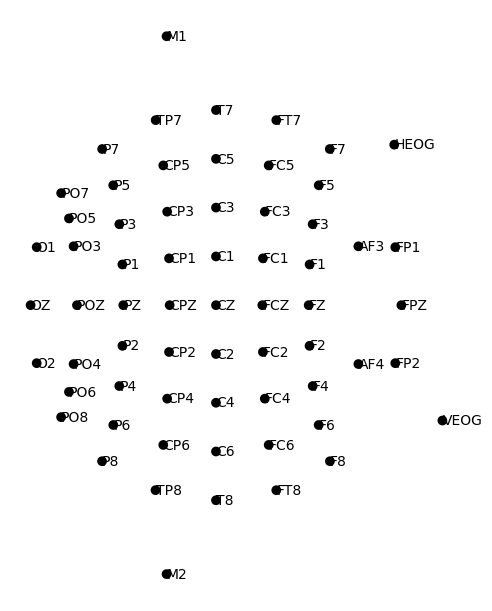

: 

In [ ]:
%matplotlib inline

# Quiet down MNE
mne.set_log_level("WARNING")

# Load data
epochs_open, epochs_closed, channel_names, channel_locs, channel_types = load_data("570_Depression_REST.mat")
print(len(channel_names), epochs_open[0].shape)

# Create MNE Info object
info = mne.create_info(ch_names = channel_names.tolist(),
                       sfreq    = 500,
                       ch_types = channel_types)
print(info)
# lowpass automatically set to freq / 2 (Nyquist frequency), highpass to 0 Hz.

# Create and apply montage
montage = mne.channels.make_dig_montage(
    ch_pos = dict(zip(channel_names, channel_locs)),
    coord_frame = 'head')
info.set_montage(montage)

# Plot topographic map
plt.rcParams["figure.figsize"] = (6, 4)
montage.plot(kind = 'topomap', show_names = True);

#### EEG - raw, bandpass filtering, CAR referencing

In [73]:
%matplotlib qt

# Plot raw EEG and its Power Spectral Density (PSD)
raw_eeg = mne.io.RawArray(epochs_open[0]/1e6, info)
raw_eeg.plot(title="Raw EEG Original")
raw_eeg.compute_psd(n_fft=2048).plot(); # semicolon stops it from rendering in the cell

In [74]:
%matplotlib qt

# Plot raw EEG w/ bandpass filter applied, and its Power Spectral Density (PSD)
raw_eeg_hp = raw_eeg.copy().filter(l_freq=1, h_freq=100) # apply a bandpass filter to a copy of the data
raw_eeg_hp.plot(duration = 10, scalings='auto', clipping = None, title="Raw EEG w/ Bandpass Filter")
raw_eeg_hp.compute_psd(n_fft=2048).plot(exclude='bads');

In [ ]:
%matplotlib qt

# Apply Common Average Reference (CAR) to the EEG channels
raw_eeg_semiclean_CAR = raw_eeg_hp.copy().set_eeg_reference(ref_channels='average', ch_type='eeg')
raw_eeg_semiclean_CAR.plot(scalings=dict(eeg=50e-6), clipping=None, show_scrollbars=True, duration=20, title='EEG w/ Filtering & CAR applied');

#### Epochs - generation, rejection, interpolation

In [75]:
%matplotlib qt

# Create and plot 4-seconds fixed-length epochs
eeg_epochs = mne.make_fixed_length_epochs(raw_eeg_hp, duration=4.0, preload=True, reject_by_annotation=False, proj=False)
eeg_epochs.plot_image(combine='mean')
eeg_epochs.plot(scalings=dict(eeg=50e-6), show_scrollbars=True, n_epochs=5, title='EEG Epochs');

In [ ]:
%matplotlib qt

# AutoReject tries interpolating 1 bad channel per epoch before rejecting the entire epoch
ar = AutoReject(n_interpolate=[1])
# ar = AutoReject(n_interpolate=[1, 2, 4, 8])
# estimate the rejection parameters and finds bad epochs
eeg_epochs_ar, reject_log = ar.fit_transform(eeg_epochs, return_log=True)
# eeg_epochs_ar contains all the epochs that are not (entirely) bad
# reject_log contains the epochs marked as bad

In [ ]:
%matplotlib qt

# Visualize rejected epochs and rejection log
eeg_epochs[reject_log.bad_epochs].plot(scalings=dict(eeg=100e-6), title='Rejected EEG Epochs (across all channels)');
reject_log.plot_epochs(eeg_epochs, scalings=dict(eeg=100e-6), title='Rejected EEG Epochs (marked per channel)');
reject_log.plot('horizontal'); # Good, bad and inerpolated channels/epochs

c:\Users\lukad\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()
c:\Users\lukad\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


#### Independent Component Analysis (ICA)

In [ ]:
# Perform and plot ICA
ica_semiclean = ICA(n_components=0.9999999, max_iter='auto', random_state=0, method='fastica') #, fit_params=dict(extended=True))
ica_semiclean.fit(raw_eeg_semiclean_CAR, reject_by_annotation=True)
ica_semiclean.plot_sources(raw_eeg_semiclean_CAR, show_scrollbars=True, theme='dark', title="ICA (from filtered and CAR applied EEG)");

print(ica_semiclean)

# even if bad channels have been interpolated, the rank of the data matrix is stil the same: check it (possible issues due to non-linear interpolation)
# assert ica_semiclean.n_components_ <= 16-len(bad_chans), "Ghost ICs appeared from data rank deficiency"

# Label ICA components
icalab = label_components(raw_eeg_semiclean_CAR, ica_semiclean, method='iclabel')
for i, label in enumerate(icalab['labels']):
    if label != 'brain':
        print(i, icalab['y_pred_proba'][i], "\t", label)

<ICA | raw data decomposition, method: fastica (fit in 570 iterations on 77379 samples), 59 ICA components (62 PCA components available), channel types: eeg, no sources marked for exclusion>


C:\Users\lukad\AppData\Local\Temp\ipykernel_75996\665644835.py:16: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  icalab = label_components(raw_eeg_semiclean_CAR, ica_semiclean, method='iclabel')


0 0.39575583 	 other
2 0.7804574 	 muscle artifact
3 0.9954995 	 muscle artifact
4 0.59334695 	 muscle artifact
7 0.9748819 	 muscle artifact
8 0.9894128 	 muscle artifact
10 0.4348055 	 other
11 0.5163217 	 muscle artifact
12 0.4339113 	 channel noise
13 0.9736318 	 muscle artifact
15 0.9677812 	 muscle artifact
16 0.9035413 	 muscle artifact
19 0.4677754 	 eye blink
21 0.59635705 	 other
22 0.9048331 	 other
23 0.9986834 	 muscle artifact
24 0.7253738 	 other
25 0.5496795 	 eye blink
26 0.5318339 	 muscle artifact
29 0.63828576 	 channel noise
30 0.81890804 	 other
31 0.6517587 	 muscle artifact
33 0.79191494 	 other
37 0.49792194 	 other
38 0.924034 	 other
40 0.5706747 	 other
41 0.42131567 	 other
42 0.7821026 	 other
43 0.6936184 	 other
44 0.9635986 	 other
45 0.9496511 	 other
46 0.9083959 	 other
48 0.9277036 	 muscle artifact
49 0.8372517 	 muscle artifact
50 0.80888754 	 other
51 0.6532134 	 other
52 0.62270194 	 other
53 0.9883733 	 other
54 0.950869 	 other
55 0.9374686 	 

In [ ]:
# Remove ICA component labeled as non-brain
raw_eeg_clean = ica_semiclean.apply(raw_eeg_semiclean_CAR)
# Interpolate bad channels (previously marked) using spline interpolation and reset their status
raw_eeg_clean.interpolate_bads(reset_bads=True, method=dict(eeg="spline"))
# Plot the cleaned EEG data
raw_eeg_clean.plot(scalings=dict(eeg=50e-6), clipping=None, duration=20, show_scrollbars=True, title="cleaned");

C:\Users\lukad\AppData\Local\Temp\ipykernel_75996\1232565915.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads(reset_bads=True, method=dict(eeg="spline"))


c:\Users\lukad\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()
